This example conducts an analysis of the initial optwrf database in an attempt to tease out relationships among the different parameters.

Last Updated by Jeffrey Sward on June 15, 2020.

In [38]:
import csv
import datetime
import math
import random
import sys
import time

import shap
import seaborn as sns
import pandas as pd
#import prince
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from optwrf.wrfparams import num2name
from optwrf.helper_functions import date2season
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Read in the optwrf csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
data = pd.read_csv('./optwrf_database_090820.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
data['fitness'].values[data['fitness'] > 6 * 10 ** 23] = np.nan
# Determine the season
data['season'] = [date2season(dat) for dat in data.start_date]
data.iloc[:5,:]


The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,ghi_error,wpd_error,runtime,season
0,2011-11-10,2,5,99,2,4,16,4,31298.680307,10831.90,56780220.0,03h 23m 16s,fall
1,2011-11-25,51,1,7,1,11,1,1,31516.466190,21342.01,41989356.0,00h 51m 09s,fall
2,2011-10-07,13,3,3,7,12,10,1,19734.008641,8762.55,30784876.0,01h 05m 24s,fall
3,2011-08-13,17,3,2,4,12,16,1,24613.299895,20582.19,13254863.0,01h 51m 31s,summer
4,2011-04-02,3,31,7,7,2,6,2,71681.216361,52733.16,64502156.0,00h 46m 48s,spring


## Random Forest Model

In this section, I train a random forest regression model to compare the relative feature importances. 

In [3]:
# Drop the start_date variable to train the random forest regressor
RFfeatures = data[['mp_physics', 'ra_lw_physics', 'ra_sw_physics', 
                  'sf_surface_physics', 'bl_pbl_physics', 'cu_physics', 
                  'fitness']]

# Drop rows where there are NaN values
RFfeatures = RFfeatures.dropna()

# Convert param_ids back to names so the RF algorithm will recognize them as separe categories
RFfeatures['mp_physics'] = num2name(RFfeatures.mp_physics, 'microphysics')
RFfeatures['ra_lw_physics'] = num2name(RFfeatures.ra_lw_physics, 'lw radiation')
RFfeatures['ra_sw_physics'] = num2name(RFfeatures.ra_sw_physics, 'sw radiation')
RFfeatures['sf_surface_physics'] = num2name(RFfeatures.sf_surface_physics, 'land surface')
RFfeatures['bl_pbl_physics'] = num2name(RFfeatures.bl_pbl_physics, 'PBL')
RFfeatures['cu_physics'] = num2name(RFfeatures.cu_physics, 'cumulus')
RFfeatures.iloc[:5,:]

,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,fitness
0,lin,new goddard,gfdl,noah,qnse,new tiedtke,31298.680307
1,p3 2mom,rrtm,flg,5 layer,shin-hong,kain-fritsch,31516.466190
2,sbu-ylin,cam,cam,pleim-xiu,gbm,mod kain-fritsch,19734.008641
3,nssl 2mom,cam,goddard,noah-mp,gbm,new tiedtke,24613.299895
4,wsm3,held-suarez,flg,pleim-xiu,myj,tiedtke,71681.216361


In [4]:
# One-hot encode the data using pandas get_dummies
RFfeatures = pd.get_dummies(RFfeatures)
RFfeatures.iloc[:5,:]

,fitness,mp_physics_cam5.1,mp_physics_goddard,mp_physics_kressler,mp_physics_lin,mp_physics_milbrandt2mom,mp_physics_morrison2mom,mp_physics_nssl 1mom,mp_physics_nssl 1mom lfo,mp_physics_nssl 2mom,...,cu_physics_grell3d,cu_physics_hwrf gfs sas,cu_physics_kain-fritsch,cu_physics_mod kain-fritsch,cu_physics_multi kain-fritsch,cu_physics_new tiedtke,cu_physics_old kain-fritsch,cu_physics_tiedtke,cu_physics_ysu gfs sas,cu_physics_zhang-mcfarlane
0,31298.680307,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,31516.466190,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,19734.008641,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,24613.299895,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,71681.216361,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# Labels are the values we want to predict
labels = RFfeatures['fitness']

# Remove the labels from the features
RFfeatures = RFfeatures.drop(['fitness'], axis = 1)
feature_names = list(RFfeatures.columns)

# Train the Random Forest Regressor model
model = RandomForestRegressor()
model.fit(RFfeatures, labels)
# print(model.feature_importances_)

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

# SHAP TreeExplainer

SHAP values represent a feature's contribution to a change in the model ouput. In contrast to the feature importances shown above which give a relative importance and are therefore comparative, SHAP values reveal if each feature pushes model output higher or lower, so therefore can be summed -- revealing the contribution that a group of features have on model output as well. 

In [6]:
# load JS visualization code to notebook
shap.initjs()

In [14]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
try:
    shap_values = explainer.shap_values(RFfeatures)
except:
    shap_values = explainer.shap_values(RFfeatures, check_additivity=False)

# Summary Plots
## SHAP Summary Plot

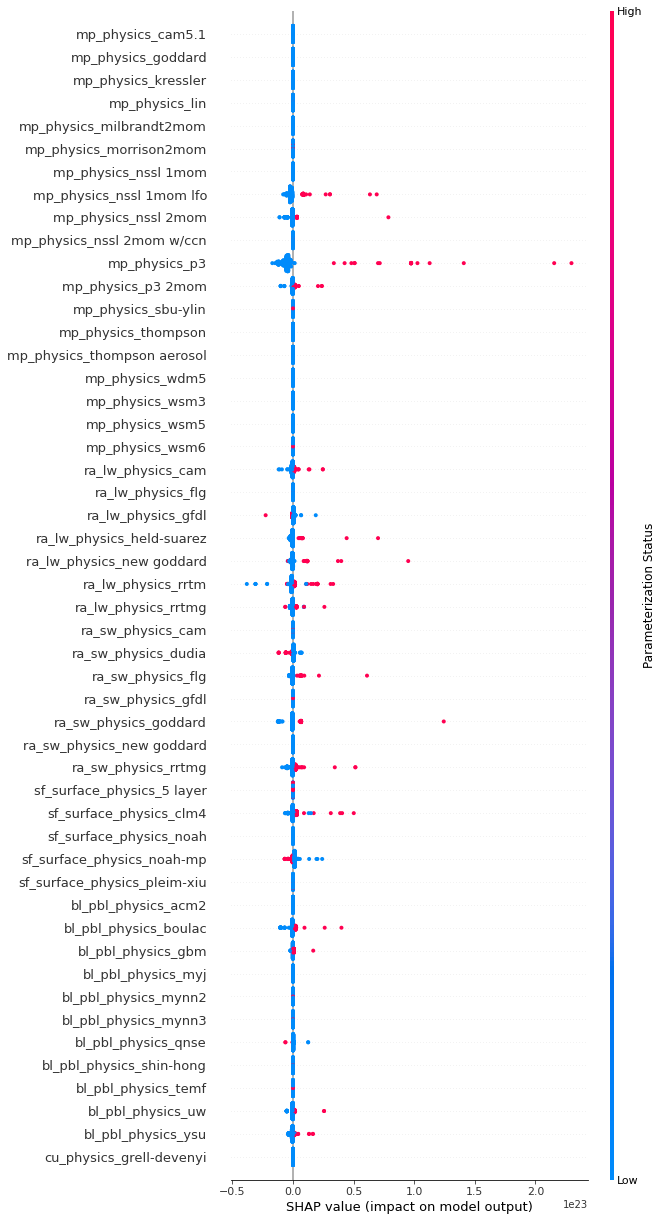

In [11]:
# summarize the effects of all the features
# NOTE: there are only two options for each feature value (1: physics scheme used; 0: physics schemem not used)
# meaning that all red dots correspond to a package being used whereas blue dots correspond to a package NOT being 
# used. Therefore, this plot can be interpreted as: red values on the left are those that push model fitness (error)
# lower, and red values on the right increase model error. The further to the right the dots fall, 
# the higher the error the use of this physics package causes. 
fig = plt.figure()
shap.summary_plot(shap_values, RFfeatures, max_display=50, color_bar_label='Parameterization Status', sort=False)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Shap_summary.pdf'
# fig.savefig(fig_path, transparent=True, bbox_inches='tight')

## Custom Summary Plot

In [42]:
# shap_data = xr.DataArray(shap_values, dims=("wrf_physics", "scheme"), coords={"scheme": feature_names})
shap_data = pd.DataFrame(shap_values, columns= feature_names)
shap_data

,mp_physics_cam5.1,mp_physics_goddard,mp_physics_kressler,mp_physics_lin,mp_physics_milbrandt2mom,mp_physics_morrison2mom,mp_physics_nssl 1mom,mp_physics_nssl 1mom lfo,mp_physics_nssl 2mom,mp_physics_nssl 2mom w/ccn,...,cu_physics_grell3d,cu_physics_hwrf gfs sas,cu_physics_kain-fritsch,cu_physics_mod kain-fritsch,cu_physics_multi kain-fritsch,cu_physics_new tiedtke,cu_physics_old kain-fritsch,cu_physics_tiedtke,cu_physics_ysu gfs sas,cu_physics_zhang-mcfarlane
0,214.255332,-4.344137,-201.070447,266.279565,-26.989907,135.919432,-379.928072,-2.259676e+21,-4.584589e+21,45.319538,...,47.056683,-6.547128e+19,-1.055785e+21,9.032055e+20,-2.075757e+20,-577.357490,3.135764e+18,-2.343994e+20,-16.281376,-22.339692
1,10.772682,-164.135377,-26.964282,27.244580,14.113163,77.522852,-87.764313,-3.911391e+21,-6.937315e+21,94.024264,...,63.756895,-5.082801e+19,6.390812e+21,9.032055e+20,-3.932925e+20,-134.447747,4.790751e+18,-6.380012e+20,-10.537336,-151.231600
2,13.982417,-4.381254,-27.483522,7.570274,12.697417,15.381198,-160.453188,-7.337858e+20,-4.822366e+20,-91.963473,...,96.298462,-1.717260e+20,-1.264542e+21,-3.440783e+20,-7.277863e+20,40.735257,3.135764e+18,-9.079654e+20,-29.201740,-20.592326
3,11.310823,-2.281104,-26.816487,75.398019,13.529347,93.544264,-153.960979,-2.372410e+21,3.310867e+21,-33.351791,...,59.800398,-6.547128e+19,-1.145133e+21,9.032055e+20,-7.277863e+20,-1108.502152,4.401073e+18,-8.345597e+20,-24.451262,-14.970815
4,13.333248,-52.802399,-135.702437,16.229860,7.922898,1491.683029,-49.102804,-5.579997e+21,-6.991447e+21,5.794374,...,29.860302,-8.652228e+19,-3.284524e+21,7.980611e+20,-1.725709e+20,-34.071402,3.135764e+18,3.674179e+22,-13.962640,-16.680612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,11.792947,-7.627682,-24.926621,-104.582908,12.325403,92.789003,-143.982356,-1.014556e+21,-4.822366e+20,62.943429,...,213.779803,4.092891e+20,-1.138054e+21,5.184903e+20,-7.610662e+20,1.131632,3.135764e+18,-4.090547e+20,-14.424148,-16.743690
363,11.078160,-3.073673,-25.278457,12.147164,13.481721,61.871104,-144.717457,-2.354662e+21,-4.690524e+20,47.615408,...,107.780053,-6.724523e+19,-1.215879e+21,9.032055e+20,-2.415303e+21,32.562540,-3.449341e+19,-1.204379e+21,-27.674606,-17.493557
364,10.006222,-7.627682,-24.702070,314.248646,10.876274,66.811288,-136.689684,-9.378730e+20,-4.822366e+20,79.289175,...,296.983480,3.875583e+20,-1.318191e+21,5.184903e+20,-7.610662e+20,7.881636,4.790751e+18,-7.266987e+20,-9.605832,-19.386405
365,9.855300,-4.504190,-24.919406,27.623771,11.721808,41.936141,-142.620695,-2.305176e+21,-4.690524e+20,41.561550,...,111.802418,-6.465823e+19,-1.338267e+21,9.032055e+20,-7.610662e+20,35.727901,-5.269826e+19,-1.526822e+21,-20.178470,-18.289007


In [52]:
scheme = shap_data.columns.str.split('_').str[0]
scheme

Index(['mp', 'mp', 'mp', 'mp', 'mp', 'mp', 'mp', 'mp', 'mp', 'mp', 'mp', 'mp',
       'mp', 'mp', 'mp', 'mp', 'mp', 'mp', 'mp', 'ra', 'ra', 'ra', 'ra', 'ra',
       'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'sf', 'sf', 'sf',
       'sf', 'sf', 'bl', 'bl', 'bl', 'bl', 'bl', 'bl', 'bl', 'bl', 'bl', 'bl',
       'bl', 'cu', 'cu', 'cu', 'cu', 'cu', 'cu', 'cu', 'cu', 'cu', 'cu', 'cu',
       'cu'],
      dtype='object')

In [63]:
mp_shap = shap_data[shap_data.columns[scheme == 'mp']]
ra_shap = shap_data[shap_data.columns[scheme == 'ra']]
sf_shap = shap_data[shap_data.columns[scheme == 'sf']]
bl_shap = shap_data[shap_data.columns[scheme == 'bl']]
cu_shap = shap_data[shap_data.columns[scheme == 'cu']]

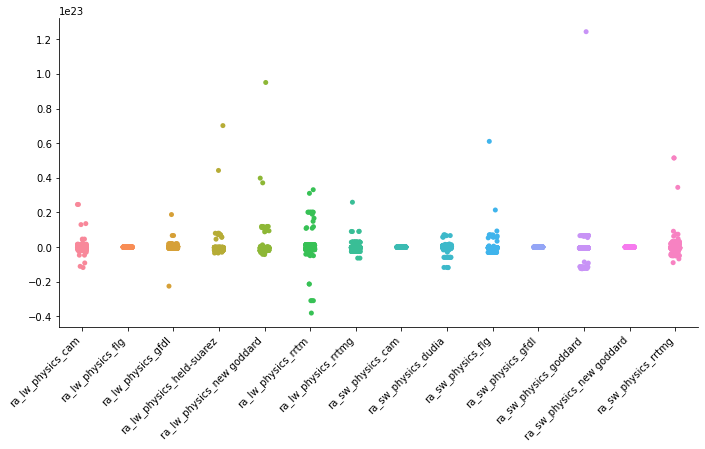

In [86]:
# Draw a seaborn catplot
catplt = sns.catplot(data=ra_shap, height=5, aspect=2)
catplt.set_xticklabels(violin.get_xticklabels(), rotation=45, horizontalalignment='right')

[Text(0, 0, 'ra_lw_physics_cam'),
 Text(1, 0, 'ra_lw_physics_flg'),
 Text(2, 0, 'ra_lw_physics_gfdl'),
 Text(3, 0, 'ra_lw_physics_held-suarez'),
 Text(4, 0, 'ra_lw_physics_new goddard'),
 Text(5, 0, 'ra_lw_physics_rrtm'),
 Text(6, 0, 'ra_lw_physics_rrtmg'),
 Text(7, 0, 'ra_sw_physics_cam'),
 Text(8, 0, 'ra_sw_physics_dudia'),
 Text(9, 0, 'ra_sw_physics_flg'),
 Text(10, 0, 'ra_sw_physics_gfdl'),
 Text(11, 0, 'ra_sw_physics_goddard'),
 Text(12, 0, 'ra_sw_physics_new goddard'),
 Text(13, 0, 'ra_sw_physics_rrtmg')]

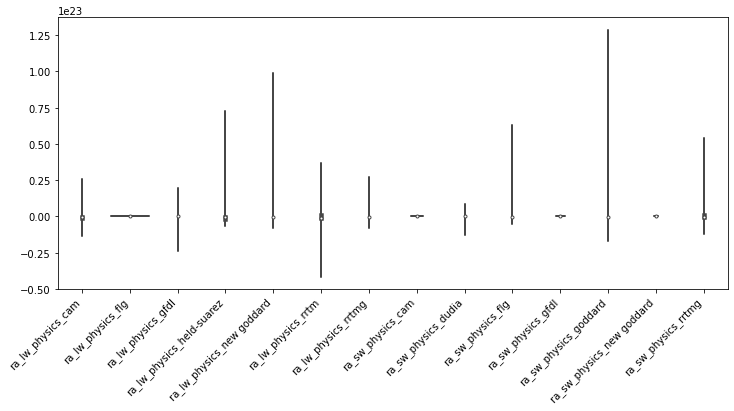

In [91]:
# Draw a nested violinplot and split the violins for easier comparison
fig, ax = plt.subplots(figsize=(12, 5))
violin = sns.violinplot(data=ra_shap,)
violin.set_xticklabels(violin.get_xticklabels(), rotation=45, horizontalalignment='right')

95.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
99.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
97.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
96.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
95.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
93.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
96.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
96.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
94.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


AttributeError: 'FacetGrid' object has no attribute 'get_xticklabels'

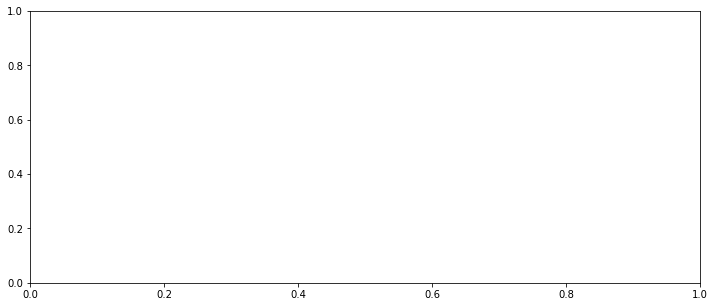

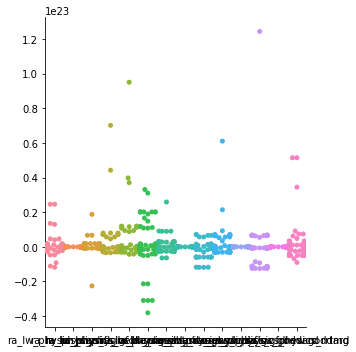

In [72]:
fig, ax = plt.subplots(figsize=(12, 5))
swarm = sns.catplot(kind="swarm", data=ra_shap)
swarm.set_xticklabels(swarm.get_xticklabels(), rotation=90)

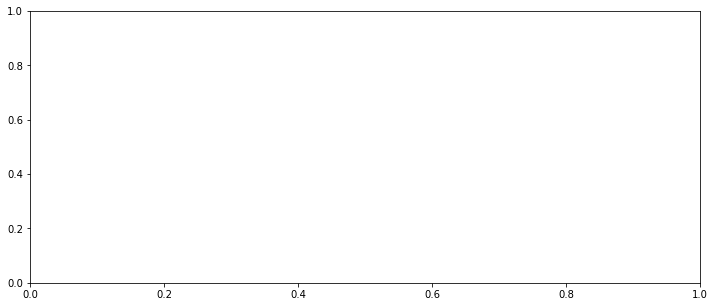

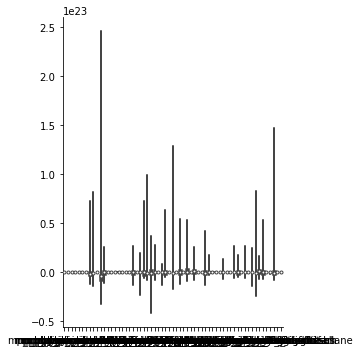

In [48]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.catplot(kind="violin", split=True, data=shap_data)